In [2]:
import numpy as np
import pandas as pd
import torch
import sys
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('/home/benoit.sautydechalon/deformetrica')

from deformetrica.core.estimator_tools.samplers.srw_mhwg_sampler import SrwMhwgSampler
from deformetrica.core.estimators.gradient_ascent import GradientAscent
from deformetrica.core.estimators.mcmc_saem import McmcSaem
# Estimators
from deformetrica.core.estimators.scipy_optimize import ScipyOptimize
from deformetrica.core.model_tools.manifolds.exponential_factory import ExponentialFactory
from deformetrica.core.model_tools.manifolds.generic_spatiotemporal_reference_frame import GenericSpatiotemporalReferenceFrame
from deformetrica.core.models.longitudinal_metric_learning import LongitudinalMetricLearning
from deformetrica.core.models.model_functions import create_regular_grid_of_points
from deformetrica.in_out.array_readers_and_writers import read_2D_array
from deformetrica.in_out.dataset_functions import read_and_create_scalar_dataset, read_and_create_image_dataset
from deformetrica.support.probability_distributions.multi_scalar_normal_distribution import MultiScalarNormalDistribution
from deformetrica.support.utilities.general_settings import Settings
from deformetrica import estimate_longitudinal_metric_model
from deformetrica.in_out.array_readers_and_writers import *
from deformetrica.launch.estimate_longitudinal_metric_model import instantiate_longitudinal_metric_model
import deformetrica as dfca

[pyKeOps]: Warning, cuda was detected, but driver API could not be initialized. Switching to cpu only.


## 1. Loading the individual parameters and raw data

In [1]:
path = 'simulated_study/'
output_folder = 'personalize_5/'

In [ ]:
rer = np.load(path+output_folder+'LongitudinalMetricModel__EstimatedParameters__IndividualRandomEffectsSamples.npy', 
              allow_pickle=True)[()]
trajectories = np.load(path+output_folder+'LongitudinalMetricModel__EstimatedParameters__Trajectory.npy',
       allow_pickle=True)[()]
ids = pd.read_csv(path+output_folder+'LongitudinalMetricModel_subject_ids_unique.txt', header=None).values

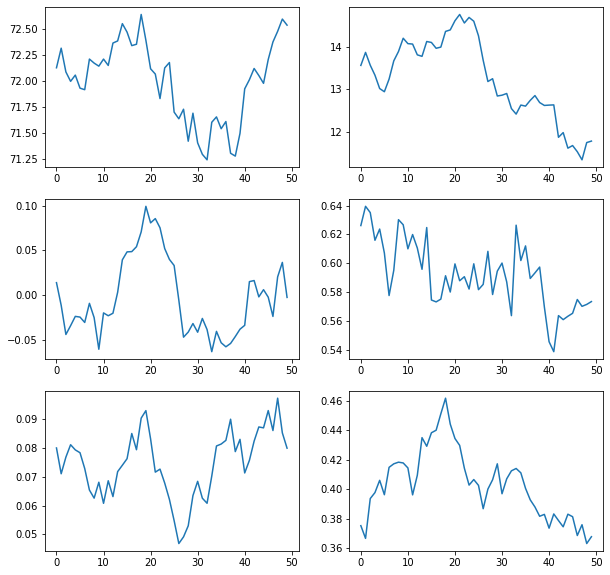

In [180]:
# Plot the non burn-in iterations
fig, axes = plt.subplots(3,2, figsize=(10,10))

axes[0][0].plot(rer['onset_age'].mean(axis=1))
axes[0][1].plot(rer['onset_age'].std(axis=1))
axes[1][0].plot(rer['log_acceleration'].mean(axis=1))
axes[1][1].plot(rer['log_acceleration'].std(axis=1))
axes[2][0].plot(rer['sources'].mean(axis=1))
axes[2][1].plot(rer['sources'].std(axis=1))

plt.show()

In [5]:
# Then in the required format for the deformetrica model

rer['onset_age'] = rer['onset_age'].mean(axis=0)
rer['log_acceleration'] = rer['log_acceleration'].mean(axis=0)
rer['sources'] = np.array([[source] for source in rer['sources'].mean(axis=0)])
averaged_rer = rer
averaged_rer

{'onset_age': array([ 71.45334796,  60.87557225,  56.81096268,  85.67214893,
         60.32979066,  63.44964174, 103.9245966 ,  92.83191348,
         36.41627641,  51.62714774,  95.00884024,  71.06143529,
         51.87449329,  71.86792188,  64.54125897,  63.60018842,
         71.91099723,  53.02136603,  55.70486947,  62.01726054,
         64.97403875,  77.05698696,  89.44385608,  52.77783832,
         73.22491155,  63.43902417,  49.82094629,  80.53407046,
         45.01278505,  74.89388988,  53.77607442,  73.98949744,
         78.31879818,  52.21042872,  64.98824218,  62.66350842,
         18.50273555,  70.29188591,  79.44111999,  57.98627381,
         69.40226802,  65.38654428,  71.652016  ,  72.7549246 ,
         66.83158571,  80.38764051,  63.97023588,  73.29367736,
         65.62672296,  69.71439598,  46.22178902,  62.87569493,
         78.8170029 ,  54.49066882,  75.00747538,  58.59942694,
         61.58754298,  55.84044972,  81.13334351,  59.34408474,
         61.33143898,  61.8

In [41]:
# First we put them in a dataframe for visualization purpose

ip = pd.DataFrame(columns=['tau','xi','source'], index=[int(idx[0]) for idx in ids])
ip['tau'] = rer['onset_age'].mean(axis=0)
ip['xi'] = rer['log_acceleration'].mean(axis=0)
ip['source'] = rer['sources'].mean(axis=0)

ip

,tau,xi,source
0,57.234959,0.013993,0.113005
1,75.403667,-0.635392,-0.013705
2,67.486395,1.067332,0.167432
3,76.939583,-0.438451,-0.009470
4,60.442647,-0.215578,0.011482
...,...,...,...
95,62.383067,-0.442946,-0.000977
96,31.692327,-0.975841,0.248329
97,84.056978,-0.876157,-0.038796
98,75.402298,-0.021838,-0.175676


In [22]:
data = pd.DataFrame(index=[ids, times], columns=['adas_memory', 'hippocampus'])
data['adas_memory'] = adas_memory
data['hippocampus'] = hippocampus
data

adas_memory  hippocampus
4    74.868477     0.407333     0.377389
     75.075706     0.518444     0.375055
     75.282936     0.466667     0.364087
     75.490158     0.540667     0.382969
     76.111847     0.511111     0.429288
...                     ...          ...
1425 78.461342     0.540667     0.242699
     79.093491     0.607333     0.267690
1430 84.350166     0.577778     0.745385
     84.780472     0.659333     0.774981
     86.071396     0.770444     0.804698

[942 rows x 2 columns]

In [181]:
times = [time[0] for time in pd.read_csv(path+output_folder+'LongitudinalMetricModel_absolute_times.txt', header=None).values]
logistic = [score[0] for score in pd.read_csv(path+'/simulated_data_5/Y.csv', header=None).values]
sum_logistic = [score[1] for score in pd.read_csv(path+'/simulated_data_5/Y.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+output_folder+'LongitudinalMetricModel_subject_ids.txt', header=None).values]

In [182]:
data = pd.DataFrame(index=[ids, times], columns=['logistic', 'sum_logistic'])
data['logistic'] = logistic
data['sum_logistic'] = sum_logistic
data

logistic  sum_logistic
0  100.364853  0.825440      0.758157
   100.857246  0.694294      0.864409
   101.349640  0.733746      0.803578
   101.842033  0.572616      0.974391
   102.334427  0.807546      0.816188
...                 ...           ...
99 75.026245   0.740701      0.581178
   75.418510   0.596949      0.658479
   75.810783   0.633617      0.734469
   76.203049   0.524243      0.633501
   76.595314   0.640262      0.621080

[800 rows x 2 columns]

In [7]:
individual_parameters = pd.read_csv(path+'/simulated_data_5/true_individual_parameters.csv').set_index('Unnamed: 0')
individual_parameters.index.name = 'ID'
individual_parameters

,xi,tau,source
ID,,,
0,-0.057622,64.533047,-2.892781
1,-0.586603,68.477432,4.401125
2,0.299599,57.162128,-2.918315
3,-1.085045,75.067964,-7.672403
4,0.114910,58.931843,-0.342369
...,...,...,...
95,0.212753,58.217001,-6.283154
96,0.672398,54.109809,-3.066973
97,-0.109101,62.784147,-1.224788


In [5]:
tau = [tau[0] for tau in pd.read_csv(path+'/preprocessing_test_2/2_gradient_descent_on_the_mode/LongitudinalMetricModel_onset_ages.txt', header=None).values]
xi = [xi[0] for xi in pd.read_csv(path+'/preprocessing_test_2/2_gradient_descent_on_the_mode/LongitudinalMetricModel_log_accelerations.txt', header=None).values]
sources = [np.float(sources) for sources in pd.read_csv(path+'/preprocessing_test_2/2_gradient_descent_on_the_mode/LongitudinalMetricModel_sources.txt', header=None).values]

individual_parameters_after_initialization = pd.DataFrame(columns=individual_parameters.columns, index=individual_parameters.index)
individual_parameters_after_initialization['tau'] = tau
individual_parameters_after_initialization['xi'] = xi
individual_parameters_after_initialization['source'] = sources

NameError: name 'individual_parameters' is not defined

In [8]:
tau = [tau[0] for tau in pd.read_csv(path+output_folder+'LongitudinalMetricModel_onset_ages.txt', header=None).values]
xi = [xi[0] for xi in pd.read_csv(path+output_folder+'LongitudinalMetricModel_log_accelerations.txt', header=None).values]
sources = [np.float(sources) for sources in pd.read_csv(path+output_folder+'LongitudinalMetricModel_sources.txt', header=None).values]

estimated_ip = pd.DataFrame(columns=individual_parameters.columns, index=individual_parameters.index)
estimated_ip['tau'] = tau
estimated_ip['xi'] = xi
estimated_ip['source'] = sources

In [10]:
individual_parameters

,xi,tau,source
ID,,,
0,-0.057622,64.533047,-2.892781
1,-0.586603,68.477432,4.401125
2,0.299599,57.162128,-2.918315
3,-1.085045,75.067964,-7.672403
4,0.114910,58.931843,-0.342369
...,...,...,...
95,0.212753,58.217001,-6.283154
96,0.672398,54.109809,-3.066973
97,-0.109101,62.784147,-1.224788


In [11]:
estimated_ip

,xi,tau,source
ID,,,
0,0.058614,69.423150,0.124957
1,-0.136671,68.182250,-0.004000
2,0.105583,67.023888,0.230308
3,-0.073364,69.339825,-0.017922
4,-0.083340,65.919538,0.013079
...,...,...,...
95,-0.164789,65.557540,0.050176
96,0.086165,62.284897,0.304947
97,-0.362451,68.184458,-0.141157


In [9]:
abs(individual_parameters - estimated_ip).describe()

INFO:numexpr.utils:Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,xi,tau,source
count,100.000000,100.000000,100.000000
mean,0.450484,6.734522,3.711165
std,0.305278,4.722212,2.640369
min,0.004599,0.077104,0.108944
25%,0.218985,3.386171,1.692013
50%,0.399582,5.977758,3.330918
75%,0.571015,8.837895,5.213570
max,1.405138,23.516124,12.620977


In [32]:
path = 'mds_study'
times = [time[0] for time in pd.read_csv(path+'/output/LongitudinalMetricModel_absolute_times.txt', header=None).values]
mds1 = [score[0] for score in pd.read_csv(path+'/mds_data/MDS_values.csv', header=None).values]
mds2 = [score[1] for score in pd.read_csv(path+'/mds_data/MDS_values.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+'/output/LongitudinalMetricModel_subject_ids.txt', header=None).values]

In [33]:
data = pd.DataFrame(index=[ids, times], columns=['mds1', 'mds2'])
data['mds1'] = mds1
data['mds2'] = mds2
data

mds1      mds2
3001 59.910362  0.500000  0.133333
     59.982315  0.571429  0.133333
     60.215916  0.500000  0.133333
     60.449516  0.500000  0.200000
     60.683113  0.571429  0.200000
...                  ...       ...
3467 71.582550  0.500000  0.733333
     71.708649  0.714286  0.800000
     71.957832  0.357143  0.733333
     72.333115  0.357143  0.666667
     72.708397  0.357143  0.733333

[3000 rows x 2 columns]

In [35]:
reconstructed = pd.read_csv('mds_study/personalize_output/LongitudinalMetricModel_reconstructed_values.txt', sep=' ', header=None)
reconstructed.columns = ['mds1', 'mds2']
reconstructed.index = data.index

In [36]:
abs(reconstructed-data).describe()

,mds1,mds2
count,3000.000000,3000.000000
mean,0.163081,0.180404
std,0.134820,0.168752
min,0.000148,0.000094
25%,0.061791,0.060085
50%,0.131837,0.135601
75%,0.231493,0.250328
max,1.103094,2.036188


## 2. Evaluating the reconstruction error

In [213]:
path = 'simulated_study'
args = {'verbosity':'INFO', 'output':'personalize',
        'model':path+'/model_pruned.xml', 'dataset':path+'/data_set.xml', 'parameters':path+'/optimization_parameters_saem.xml'}


"""
Read xml files, set general settings, and call the adapted function.
"""

xml_parameters = dfca.io.XmlParameters()
xml_parameters.read_all_xmls(args['model'],
                             args['dataset'],
                             args['parameters'])

logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logger.setLevel(logging.INFO)

/home/benoit.sautydechalon/deformetrica/deformetrica/in_out/xml_parameters.py:579: UserWarning: Unknown entry while parsing the optimization_parameters xml: number-of-threads
  warnings.warn(msg)


In [214]:
dataset = read_and_create_scalar_dataset(xml_parameters)
model, individual_RER = instantiate_longitudinal_metric_model(xml_parameters, logger, dataset, observation_type='scalar')

INFO:__main__:Setting initial onset ages from simulated_study/output_5/LongitudinalMetricModel_onset_ages.txt file
INFO:__main__:Setting initial log accelerations from simulated_study/output_5/LongitudinalMetricModel_log_accelerations.txt file
INFO:__main__:Initializing exponential type to parametric
INFO:__main__:Loading metric parameters from file simulated_study/output_5_kernel_0.15/LongitudinalMetricModel_metric_parameters.txt
INFO:__main__:Loading the interpolation points from file simulated_study/output_5_kernel_0.15/LongitudinalMetricModel_interpolation_points.txt
INFO:__main__:The width for the metric interpolation is set to 0.15
INFO:__main__:I am setting the no_parallel_transport flag to False.
INFO:__main__:>> Reading 1-source initial modulation matrix from file: simulated_study/output_5/LongitudinalMetricModel_modulation_matrix.txt
INFO:__main__:Setting initial sources from simulated_study/personalize_pruned_5/LongitudinalMetricModel_sources.txt file
INFO:deformetrica.core.

Patient  56  was estimated with an absurd timeshift tensor(125.7517)
Patient  63  was estimated with an absurd timeshift tensor(123.6832)
In geodesic update ,  40 70.35840155118882 110


INFO:deformetrica.core.models.longitudinal_metric_learning:Tmin 40 Tmax 110 Update of the spatiotemporalframe: 2928 ms
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints above tmax
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints above tmax
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints above tmax
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints above tmax
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints below tmin
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints below tmin
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints below tmin
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints below tmin
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to est

In [215]:
v0, p0, metric_parameters, modulation_matrix = model._fixed_effects_to_torch_tensors(False)
onset_ages, log_accelerations, sources = model._individual_RER_to_torch_tensors(individual_RER, False)
t0 = model.get_reference_time()

absolute_times = model._compute_absolute_times(dataset.times, log_accelerations, onset_ages)

absolute_times_to_write = []
for elt in absolute_times:
    for e in elt.cpu().data.numpy():
        absolute_times_to_write.append(e)

#np.savetxt(os.path.join(Settings().output_dir, "LongitudinalMetricModel_absolute_times.txt"), np.array(absolute_times_to_write))

model._update_spatiotemporal_reference_frame(absolute_times, p0, v0, metric_parameters,
                                            modulation_matrix)

INFO:deformetrica.core.models.longitudinal_metric_learning:Acceleration factors max/min: (3.320117, 62, 0.3782825, 96)


Patient  56  was estimated with an absurd timeshift tensor(125.7517)
Patient  63  was estimated with an absurd timeshift tensor(123.6832)
In geodesic update ,  40 70.35840155118882 110


INFO:deformetrica.core.models.longitudinal_metric_learning:Tmin 40 Tmax 110 Update of the spatiotemporalframe: 3457 ms


In [216]:
predictions = []
subject_ids = []
times = []

targets = dataset.deformable_objects

number_of_subjects = dataset.number_of_subjects
residuals = []

for i in range(number_of_subjects):
    predictions_i = []
    for j, t in enumerate(absolute_times[i]):
        if sources is not None:
            prediction = model.spatiotemporal_reference_frame.get_position(t, sources=sources[i])
        else:
            prediction = model.spatiotemporal_reference_frame.get_position(t)
        predictions_i.append(prediction.cpu().data.numpy())
        predictions.append(prediction.cpu().data.numpy())
        subject_ids.append(dataset.subject_ids[i])
        times.append(dataset.times[i][j])

    targets_i = targets[i].cpu().data.numpy()


INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints above tmax
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints above tmax
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints above tmax
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints above tmax
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints below tmin
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints below tmin
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints below tmin
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints below tmin
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints below tmin
INFO:deformetrica.core.model_tools.manifolds.generic_geodesic:Want to estimate timepoints b

In [217]:
predicted = data.copy()
predicted['logistic'] = [prediction[0] for prediction in predictions]
predicted['sum_logistic'] = [prediction[1] for prediction in predictions]

In [218]:
diff = predicted - data
abs(diff).describe()

,logistic,sum_logistic
count,800.000000,800.000000
mean,0.060997,0.063588
std,0.047167,0.048337
min,0.000041,0.000107
25%,0.023743,0.025615
50%,0.050612,0.054457
75%,0.086390,0.090299
max,0.306470,0.301763


In [219]:
predicted.describe()

,logistic,sum_logistic
count,800.000000,800.000000
mean,0.510975,0.676770
std,0.153604,0.131848
min,0.260475,0.419405
25%,0.366265,0.601256
50%,0.531329,0.668982
75%,0.667589,0.741139
max,0.759880,0.961529


In [220]:
data.describe(percentiles=[.9])

,logistic,sum_logistic
count,800.000000,800.000000
mean,0.510620,0.655286
std,0.189256,0.162464
min,0.084783,0.136826
50%,0.516825,0.654417
90%,0.756454,0.867518
max,0.974269,1.095116


## Geodesic visualization

In [221]:
study = 'bivariate_study/'
output_folder = 'output/'

geodesic = pd.read_csv(study+output_folder+'LongitudinalMetricModel_reference_geodesic_trajectory_values.txt', sep=' ', header=None)
source_pos = pd.read_csv(study+output_folder+'LongitudinalMetricModel_source_0_pos.txt', sep=' ', header=None)
source_neg = pd.read_csv(study+output_folder+'LongitudinalMetricModel_source_0_neg.txt', sep=' ', header=None)

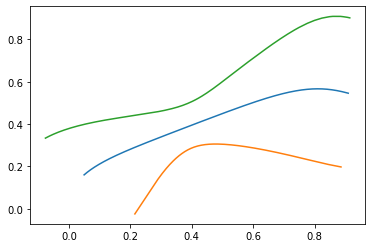

In [222]:
plt.plot(geodesic[0].values, geodesic[1].values)
plt.plot(source_pos[0].values, source_pos[1].values)
plt.plot(source_neg[0].values, source_neg[1].values)
plt.show()